In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

import preprocess # helper preprocessing class
import ode_solver_pyomo_base
import ode_solver_pyomo_opt

# pyomo
import importlib
import nn_pyomo_base
import nn_pyomo_base_dae

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

In [15]:
# reload the necessary libraries
importlib.reload(nn_pyomo_base)
NeuralODEPyomo = nn_pyomo_base.NeuralODEPyomo

importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

importlib.reload(ode_solver_pyomo_opt)
DirectODESolver = ode_solver_pyomo_opt.DirectODESolver

# set up data parameters
file_path = '../00_data/df_train.csv'
# , 'temperature': 'var1'                                               
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

# fix model parameters 
layer_sizes = [7, 30, 1]

# fix optimal parameters
tol = 1e-8
params_nn = {"tol" : 1e-8, 
        # "dual_inf_tol": 1e-6, "compl_inf_tol": 1e-6, "constr_viol_tol": 1e-6, 
        "halt_on_ampl_error" : 'yes', "print_level": 1, "max_iter": 1000}

tol = 1e-4
params_ode = {"tol":1e-4, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_iter": 0,  
        "halt_on_ampl_error" : 'yes',
        "print_level": 1, 
        "max_iter": 300 }

In [16]:
from datetime import datetime, timedelta

# prepare data ranges
START_DATE = '2015-01-10'
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
date_sequences = [start_date + timedelta(days=i*5) for i in range(10)]
date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
print(date_sequences_str)

times_elapsed = []

['2015-01-10', '2015-01-15', '2015-01-20', '2015-01-25', '2015-01-30', '2015-02-04', '2015-02-09', '2015-02-14', '2015-02-19', '2015-02-24']


In [17]:
def clear_folder(folder_path):
    # Check if folder exists
    if os.path.exists(folder_path):
        # Remove all contents within the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                os.unlink(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        # If folder doesn't exist, create it
        os.makedirs(folder_path)
        print(f"Folder {folder_path} created")


In [18]:
experiment_results = {}
folder_path = 'plots/pyomo'
clear_folder(folder_path)
PENALTY = 0.01
    
for START_DATE in date_sequences_str:
    data_loader = DataPreprocessor(file_path, start_date = START_DATE, number_of_points = 400, n_days = 1, m = 1, feature_encoding = encoding, split=200)
    data_subsample = data_loader.load_data()
    df_train, df_test = data_loader.preprocess_data(data_subsample)

    ys = np.atleast_2d(df_train['y']).T
    ts = np.array(df_train['t'])
    Xs = np.atleast_2d(df_train.drop(columns=['y', 't']))

    w = compute_weights(df_train['t'])
    Ds = np.array(lagrange_derivative(df_train['t'], w))

    ode_model = NeuralODEPyomo(y_observed = ys, 
                            t = ts, # t
                            first_derivative_matrix = Ds, # derivative matrix
                            extra_input = Xs, # extra inputs
                            y_init = ys,
                            layer_sizes = layer_sizes, act_func = "tanh", 
                            penalty_lambda_reg = PENALTY, 
                            time_invariant = True,
                            w_init_method = 'xavier', 
                            params = params_nn
                            )

    ode_model.build_model()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution().T
    
    experiment_results[START_DATE] = {}
    experiment_results[START_DATE]['times_elapsed'] = result['solver_time']
    
    # ---------------------------------------------- ODEINT PREDICTION ----------------------------------------------
    y0 = ys[0]
    y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))
    
    plt.figure(figsize=(20, 10))
    plt.plot(ts, ys, label='True Data', alpha = 1)
    plt.plot(ts, u_model, label='True Data', alpha = 1)
    plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint', alpha = 0.7)
    plt.title(f"Sequential ODE solver Result; Time Elapsed: {result['solver_time']}")
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.savefig(f'plots/pyomo/ode_solver_train_{START_DATE}.png', format='png')  
    plt.close() 
    
    experiment_results[START_DATE]['mae_odeint'] = np.mean(np.abs(np.squeeze(y_pred) - np.squeeze(ys)))
    experiment_results[START_DATE]['mse_odeint'] = np.mean(np.square(np.squeeze(y_pred) - np.squeeze(ys)))
    
    # -------------------------------------------- COLLOCATION PREDICTION (TRAIN) ---------------------------------------------- 
    # extract weights & biases
    trained_weights_biases = ode_model.extract_weights()  
    
    # set up and solve the model
    initial_state = u_model[0]
    direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights_biases, initial_state, 
                                    D = Ds, 
                                    time_invariant=True, extra_input=np.array(Xs), params = params_ode)
    direct_solver.build_model()
    solver_info = direct_solver.solve_model()
    y_solution = direct_solver.extract_solution()     
    
    plt.figure(figsize=(20, 10))
    plt.plot(ts, ys, label='True Data', alpha = 1)
    plt.plot(ts, u_model, label='True Data', alpha = 1)
    plt.plot(ts, y_solution, label='Model Prediction (Train) - Collocation-based ODE', alpha = 0.7)
    plt.title(f"Collocation-based ODE solver Result; Time Elapsed: {result['solver_time']}")
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.savefig(f'plots/pyomo/collocation_solver_train_{START_DATE}.png', format='png')  
    plt.close() 
    
    experiment_results[START_DATE]['mae_coll_ode'] = np.mean(np.abs(np.squeeze(y_solution) - np.squeeze(ys)))
    experiment_results[START_DATE]['mse_coll_ode'] = np.mean(np.square(np.squeeze(y_solution) - np.squeeze(ys)))
    
    # ---------------------------------------- ODEINT & COLLOCATION PREDICTION (TEST) ----------------------------------------- 
    ys_test = np.atleast_2d(df_test['y']).T
    ts_test = np.array(df_test['t'])
    Xs_test = np.atleast_2d(df_test.drop(columns=['y', 't']))
    w_test = compute_weights(df_test['t'])
    Ds_test = np.array(lagrange_derivative(df_test['t'].values, w_test))
    
    # odeint prediction
    y_pred_test = ode_model.neural_ode(ys_test[0], ts_test, (Xs_test, ts_test))
    
    plt.figure(figsize=(20, 10))
    plt.plot(ts_test, ys_test)
    plt.plot(ts_test, y_pred_test, label='Model Prediction (Test) -  Odeint', alpha = 0.7)
    plt.title(f"Odeint ODE solver Result (Test); Time Elapsed: {result['solver_time']}")
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.savefig(f'plots/pyomo/ode_solver_test_{START_DATE}.png', format='png')  
    plt.close() 
    
    experiment_results[START_DATE]['mae_odeint_test'] = np.mean(np.abs(np.squeeze(y_pred_test) - np.squeeze(ys_test)))
    experiment_results[START_DATE]['mse_odeint_test'] = np.mean(np.square(np.squeeze(y_pred_test) - np.squeeze(ys_test)))
    
    y0_test = ys_test[0][0]
    direct_solver = DirectODESolver(ts_test, layer_sizes, trained_weights_biases, y0_test, 
                                    D = Ds_test,
                                    time_invariant=True, extra_input=np.array(Xs_test), params = params_ode)
    direct_solver.build_model()
    
    solver_info = direct_solver.solve_model()
    y_solution_test = direct_solver.extract_solution() 
    
    plt.figure(figsize=(20, 10))
    plt.plot(ts_test, ys_test)
    plt.plot(ts_test, y_solution_test, label='Model Prediction (Test) -  Collocation-based ODE', alpha = 0.7)
    plt.title(f"Collocation-based ODE solver Result (Test); Time Elapsed: {result['solver_time']}")
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.savefig(f'plots/pyomo/collocation_solver_test_{START_DATE}.png', format='png')  
    plt.close() 
    
    experiment_results[START_DATE]['mae_coll_ode_test'] = np.mean(np.abs(np.squeeze(y_solution_test) - np.squeeze(ys_test)))
    experiment_results[START_DATE]['mse_coll_ode_test'] = np.mean(np.square(np.squeeze(y_solution_test) - np.squeeze(ys_test)))
    
    print(f"Processing for {START_DATE} is complete")

y
Ipopt 3.14.16: tol=1e-08
halt_on_ampl_error=yes
print_level=1
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=300


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
********************************************************************

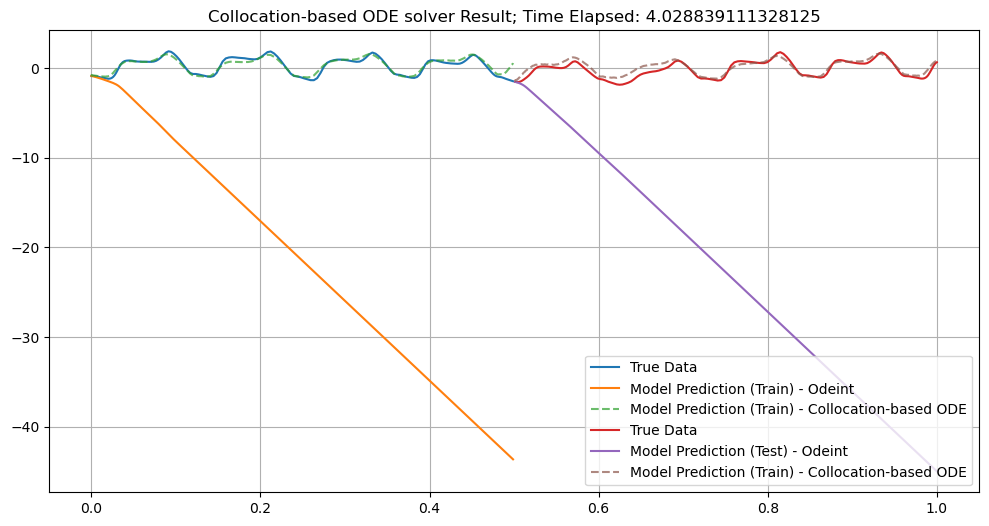

In [19]:
display = True

if display:
    plt.figure(figsize=(12, 6))
    plt.plot(ts, ys, label='True Data', alpha = 1)
    plt.plot(ts, y_pred, label='Model Prediction (Train) - Odeint', alpha = 1)
    plt.plot(ts, y_solution, '--', label='Model Prediction (Train) - Collocation-based ODE', alpha = 0.7)
    
    plt.plot(ts_test, ys_test, label='True Data', alpha = 1)
    plt.plot(ts_test, y_pred_test, label='Model Prediction (Test) - Odeint', alpha = 1)
    plt.plot(ts_test, y_solution_test, '--', label='Model Prediction (Train) - Collocation-based ODE', alpha = 0.7)
    
    plt.title(f"Collocation-based ODE solver Result; Time Elapsed: {result['solver_time']}")
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.show()

In [21]:
print(f"MAE train (odeint): {np.mean([experiment_results[k]['mae_odeint'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([experiment_results[k]['mae_odeint_test'] for k in experiment_results.keys()]):.3f}")
print(f"MAE train: {np.mean([experiment_results[k]['mae_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test: {np.mean([experiment_results[k]['mae_coll_ode_test'] for k in experiment_results.keys()]):.3}")
print(f"MSE train: {np.mean([experiment_results[k]['mse_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"MSE test: {np.mean([experiment_results[k]['mse_coll_ode_test'] for k in experiment_results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([experiment_results[k]['times_elapsed'] for k in experiment_results.keys()]):.3} seconds")

MAE train (odeint): 12.536
MAE test (odeint): 14.543
MAE train: 0.398
MAE test: 0.542
MSE train: 0.441
MSE test: 0.639
Avg sovler time elapsed: 4.05 seconds
